In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
import shutil

from torchinfo import summary
import torch.utils.tensorboard as tb

import models
import mnist

torch.manual_seed(0);

In [3]:
# import tempfile
# tb_log_dir = tempfile.mkdtemp()
user = os.getlogin()
# tb_log_dir = os.path.join(cp.data_dir, 'tensorboard/', user)
tb_log_dir = f'/tmp/tensorboard/{user}'
# print(tb_log_dir)
    

In [ ]:
if os.path.exists(tb_log_dir):
    shutil.rmtree(tb_log_dir)

In [4]:
logger = tb.SummaryWriter(tb_log_dir)

In [5]:
X_train, Y_train = [], []
for X_batch, Y_batch in tqdm(mnist.train_loader):
    X_train.append(X_batch)
    Y_train.append(Y_batch)

  0%|          | 0/938 [00:00<?, ?it/s]

In [6]:
batch_idx = 0
def calc_pheo_fitness(net):
    global batch_idx
#     batch_idx, (X_batch, Y_batch) = next(enumerate(mnist.train_loader))
    X_batch, Y_batch = X_train[batch_idx], Y_train[batch_idx]
#     batch_idx = (batch_idx+1)%len(X_train)
    
    Y_batch_pred = net(X_batch)
    n_correct = (Y_batch_pred.argmax(dim=-1)==Y_batch).sum().item()
    loss = mnist.loss_func(Y_batch_pred.log(), Y_batch).item()
    accuracy = n_correct/len(Y_batch)
    return loss, accuracy

In [7]:
model = models.SmallNet

def to_np_array(population):
    pop = np.empty(len(population), dtype=object)
    for i in range(len(pop)):
        pop[i] = population[i]
    return pop

def get_init_population():
    pop = [nn.utils.parameters_to_vector(model().parameters()).detach() for _ in range(30)]
    pop = to_np_array(pop)
    return pop

def geno2pheno():
    pass
def pheno2geno():
    pass

def calc_fitnesses(population):
    agent = model()
    fitnesses = []
    fitnesses_acc = []
    for dna in population:
        nn.utils.vector_to_parameters(dna, agent.parameters())
#         fitness = -perform_stats(agent, train_loader, n_batches=1, show_stats=False, tqdm=None)[0]
        nll, acc = calc_pheo_fitness(agent)
        fitnesses.append(-nll)
        fitnesses_acc.append(acc)
    return {'nll': fitnesses, 'accuracy': fitnesses_acc}

def calc_mutate(pop):
    mutant = [d+1e-2*torch.randn_like(d) for d in pop]
    return mutant

def calc_mutate(pop):
    mutant = []
    for p in pop:
        pm = p.clone()
        mutate_mask = torch.rand_like(pm)<0.01
        pm[mutate_mask] = torch.randn(mutate_mask.sum())
        mutant.append(pm)
    return mutant

def calc_crossover(pop1, pop2):
    cross = [torch.stack([d1, d2], dim=0).mean(dim=0) for d1, d2 in zip(pop1, pop2)]
    return cross
    
def calc_next_population(population):
    fitnesses = calc_fitnesses(population)
    N = len(population)
    npop = []
    
    n_keep_best = int(.1*N)
    npop.extend(population[np.argsort(fitnesses['nll'])[-n_keep_best:]])
    
    prob = torch.tensor(fitnesses['nll']).softmax(dim=-1).numpy()
    
    n_parents = int(.0*N)
    n_mutants = N-n_keep_best-n_parents
    
    mutants = np.random.choice(population, size=n_mutants, p=prob)
    mutants = calc_mutate(mutants)
    parents1 = np.random.choice(population, size=n_parents, p=prob)
    parents2 = np.random.choice(population, size=n_parents, p=prob)
    children = calc_crossover(parents1, parents2)
    
    npop.extend(mutants)
    npop.extend(children)
    
    npop = to_np_array(npop)
    return npop, fitnesses
    
    

population = get_init_population()
for gen_idx in tqdm(range(500)):
    population, fitnesses = calc_next_population(population)
    
    nll = np.array(fitnesses['nll'])
    acc = np.array(fitnesses['accuracy'])
#     nll = nll[(nll-nll.mean())<2*nll.std()]
#     logger.add_histogram('nll', nll, global_step=gen_idx)
#     logger.add_histogram('accuracy', acc, global_step=gen_idx)
#     logger.add_scalars('1000 BATCH SIZE, different batch, some perturbed', 
#                        {'best': np.max(fitnesses['nll']),
#                         'median': np.median(fitnesses['nll']),}, global_step=gen_idx)
#     if gen_idx%20==0:
#         a = torch.stack(list(population))
#         plt.figure(figsize=(5, 5))
#         plt.imshow((a[:, None, :]-a[None, :, :]).norm(dim=-1))
#         plt.colorbar()
#         logger.add_figure('similarity', plt.gcf(), global_step=gen_idx)


  0%|          | 0/500 [00:00<?, ?it/s]

In [8]:
net = model()
v = population[np.argmax(fitnesses['nll'])]
nn.utils.vector_to_parameters(v, net.parameters())


In [17]:
mnist.perform_stats(net, mnist.test_loader)

Average Loss: 1.867, Accuracy: 35.790%


(1.8669695258140564, 0.3579)

In [10]:
mnist.perform_stats(net, mnist.test_loader)

Average Loss: 2.785, Accuracy: 41.430%


(2.7850720167160032, 0.4143)

# Now, we are going to learn the crossover function

In [6]:
model = models.SmallNet
net = model()
v = torch.nn.utils.parameters_to_vector(net.parameters())
torch.nn.utils.vector_to_parameters(v, net.parameters())
dna_len = len(v)

In [7]:
class CONet(nn.Module):
    def __init__(self, amount=1e-2):
        super().__init__()
        n = dna_len

        self.lin1 = nn.Linear(n, n)
        self.lin2 = nn.Linear(2*n, n)
        self.lin3 = nn.Linear(n, n)
        self.amount = amount

    def forward(self, x):
        a, b = x[:, 0, :], x[:, 1, :]
        bs = len(x)
        x = torch.sigmoid(self.lin1(x))
        x = x.reshape(bs, -1)
        x = torch.sigmoid(self.lin2(x))
        x = torch.sigmoid(self.lin3(x))
        return (a+b)/2. + x*self.amount

conet = CONet()
summary(conet, input_size=(1, 2, dna_len))

Layer (type:depth-idx)                   Output Shape              Param #
CONet                                    --                        --
├─Linear: 1-1                            [1, 2, 130]               17,030
├─Linear: 1-2                            [1, 130]                  33,930
├─Linear: 1-3                            [1, 130]                  17,030
Total params: 67,990
Trainable params: 67,990
Non-trainable params: 0
Total mult-adds (M): 0.07
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.27
Estimated Total Size (MB): 0.28

# two ideas need to pursued:
- having a population of agents and a separate population of crossover networks
- having a population of male and female agents, where female agents consist of an overhead crossover network

## below is implementation of a male-female system

In [8]:
class DNA():
    def __init__(self):
        self.geno = None
        self.co_geno = None # will be None if male


model = models.SmallNet
comodel = CONet

def to_np_array(population):
    pop = np.empty(len(population), dtype=object)
    for i in range(len(pop)):
        pop[i] = population[i]
    return pop

def get_init_population():
    pop = [DNA() for _ in range(100)]
    for i in range(100):
        pop[i].geno = nn.utils.parameters_to_vector(model().parameters()).detach()
    for i in range(50):
        pop[i].co_geno = nn.utils.parameters_to_vector(comodel().parameters()).detach()
    pop = to_np_array(pop)
    return pop[:50], pop[50:]

def geno2pheno():
    pass
def pheno2geno():
    pass

def calc_fitnesses(population):
    agent = model()
    fitnesses = []
    fitnesses_acc = []
    for dna in population:
        nn.utils.vector_to_parameters(dna.geno, agent.parameters())
#         fitness = -perform_stats(agent, train_loader, n_batches=1, show_stats=False, tqdm=None)[0]
        nll, acc = calc_pheo_fitness(agent)
        fitnesses.append(-nll)
        fitnesses_acc.append(acc)
    return {'nll': fitnesses, 'accuracy': fitnesses_acc}

def calc_mutate(pop):
    mutant = [DNA() for _ in pop]
    for o, m in zip(pop, mutant):
        if o.geno is not None:
            m.geno = o.geno + 1e-2*torch.randn_like(o.geno)
        if o.co_geno is not None:
            m.co_geno = o.co_geno + 1e-2*torch.randn_like(o.co_geno)
    return mutant

def calc_crossover(popf, popm):
    children = [DNA() for _ in popf]
    conet = comodel(amount)
    for i in range(len(children)):
        x = torch.stack([popf[i].geno, popm[i].geno], dim=0)
        cogeno = popf[i].co_geno
        nn.utils.vector_to_parameters(cogeno, conet.parameters())
        y = conet(x[None])[0]
        children[i].geno = y
    for i in torch.randperm(len(popf))[:len(popf)//2]:
        children[i].co_geno = popf[i].co_geno
        
    childrenf = [c for c in children if c.co_geno is not None]
    childrenm = [c for c in children if c.co_geno is None]
    return childrenf, childrenm
    
def calc_next_population(pop_f, pop_m):
    fit_f = calc_fitnesses(pop_f)
    fit_m = calc_fitnesses(pop_m)
    
    N_f = len(pop_f)
    N_m = len(pop_m)
    
    npop = []
    
    n_keep_best = 5
    npop.extend(pop_f[np.argsort(fit_f['nll'])[-n_keep_best:]])
    npop.extend(pop_m[np.argsort(fit_m['nll'])[-n_keep_best:]])
    
    prob_f = torch.tensor(fit_f['nll']).softmax(dim=-1).numpy()
    prob_m = torch.tensor(fit_m['nll']).softmax(dim=-1).numpy()
    
#     n_parents = 30
#     n_mutants = 30
    n_parents = 10
    n_mutants = 40
    
    mutants_f = np.random.choice(pop_f, size=n_mutants, p=prob_f)
    mutants_m = np.random.choice(pop_m, size=n_mutants, p=prob_m)
    mutants_f = calc_mutate(mutants_f)
    mutants_m = calc_mutate(mutants_m)
    
    parents_f = np.random.choice(pop_f, size=n_parents, p=prob_f)
    parents_m = np.random.choice(pop_m, size=n_parents, p=prob_m)
    children_f, children_m = calc_crossover(parents_f, parents_m)
    
    npop.extend(mutants_f)
    npop.extend(mutants_m)
    npop.extend(children_f)
    npop.extend(children_m)
    
    npop_f = [c for c in npop if c.co_geno is not None]
    npop_m = [c for c in npop if c.co_geno is None]

    npop_f = to_np_array(npop_f)
    npop_m = to_np_array(npop_m)
    return npop_f, npop_m, fit_f, fit_m

amounts = [1e-9, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
n_trials = 15
n_gens = 1000
data = torch.zeros(n_trials, len(amounts), n_gens)
for trial_idx in tqdm(range(n_trials)):
    torch.manual_seed(trial_idx)
    np.random.seed(trial_idx)
    for a_idx, amount in enumerate(tqdm(amounts, leave=False)):
        pop_f, pop_m = get_init_population()
        for gen_idx in tqdm(range(n_gens), leave=False):
            pop_f, pop_m, fit_f, fit_m = calc_next_population(pop_f, pop_m)
            best_fit = max(np.max(fit_f['nll']), np.max(fit_m['nll']))

            s = f'{amount:.2e}'
#             logger.add_histogram(f'co{s} female nll', np.array(fit_f['nll']), global_step=gen_idx)
#             logger.add_histogram(f'co{s} male nll', np.array(fit_m['nll']), global_step=gen_idx)
#             logger.add_histogram(f'co{s} female accuracy', np.array(fit_f['accuracy']), global_step=gen_idx)
#             logger.add_histogram(f'co{s} male accuracy', np.array(fit_m['accuracy']), global_step=gen_idx)
#             logger.add_scalar(f'co{s} best', best_fit, global_step=gen_idx)
            
            data[trial_idx, a_idx, gen_idx] = best_fit

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
for a_idx, amount in enumerate(amounts):
    print(f'mean: {data[:, a_idx, -1].mean(dim=0): .3f}, std: {data[:, a_idx, -1].std(dim=0):.3f}, amount:{amounts[a_idx]: .1e}')

mean: -0.523, std: 0.497, amount: 1.0e-09
mean: -0.480, std: 0.197, amount: 1.0e-03
mean: -0.577, std: 0.182, amount: 1.0e-02
mean: -0.341, std: 0.111, amount: 1.0e-01
mean: -0.355, std: 0.136, amount: 1.0e+00
mean: -0.342, std: 0.147, amount: 1.0e+01


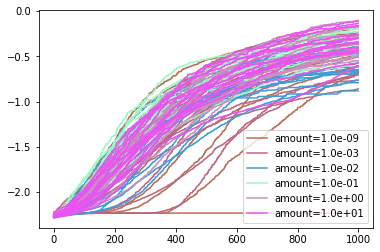

In [24]:
for a_idx, amount in enumerate(amounts):
    c = np.random.uniform(size=3)
    for trial_idx in range(15):
        label=None
        if trial_idx==0:
            label=label=f'amount={amount:.1e}'
        plt.errorbar(np.arange(1000), data[trial_idx, a_idx].numpy(), yerr=None, c=c, label=label)
plt.legend()

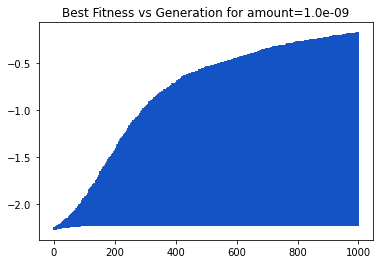

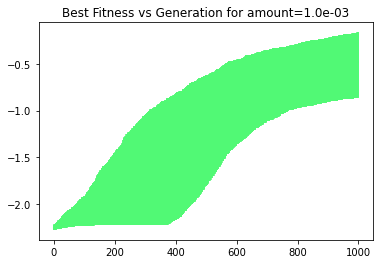

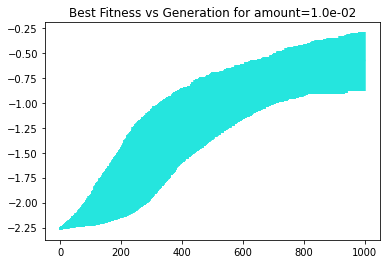

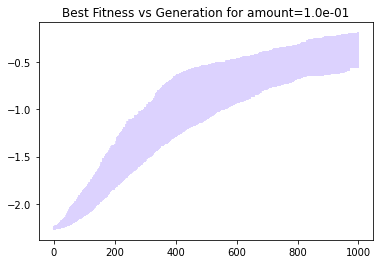

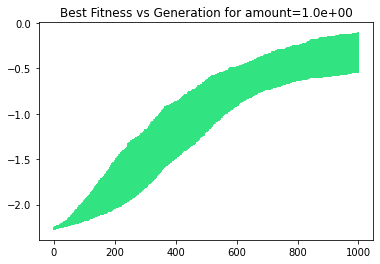

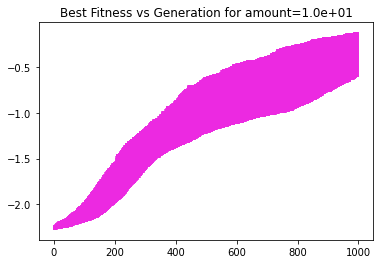

In [28]:
for a_idx, amount in enumerate(amounts):
    c = np.random.uniform(size=3)
    label=label=f'amount={amount:.1e}'
    d = data[:, a_idx]
    yerr = d.std(dim=0)
    yerr = torch.stack([d.min(dim=0).values-d.mean(dim=0), d.max(dim=0).values-d.mean(dim=0)], dim=0).abs()
    plt.errorbar(np.arange(1000), d.mean(dim=0).numpy(),
                 yerr=yerr.numpy(), c=c, label=label)
    plt.title(f'Best Fitness vs Generation for amount={amount:.1e}')
    plt.show()
# plt.legend()

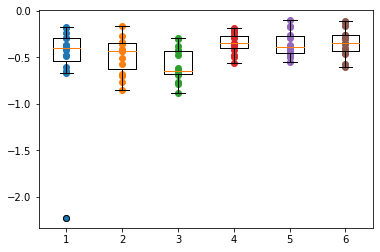

In [56]:
# for a_idx, amount in enumerate(amounts):
#     plt.boxplot(data[:, a_idx, -1].numpy())
plt.boxplot(data[:, :, -1].numpy())

for a_idx, amount in enumerate(amounts):
    d = data[:, a_idx, -1]
    plt.scatter(np.ones_like(d)*(a_idx+1), d.numpy())
plt.show()

In [30]:
data.numel()

90000

torch.Size([15, 3, 500])

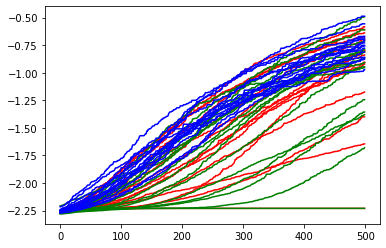

In [53]:
for trial_idx in range(15):
    plt.errorbar(np.arange(500), d[trial_idx, 0].numpy(), yerr=None, c='r')
for trial_idx in range(15):
    plt.errorbar(np.arange(500), d[trial_idx, 1].numpy(), yerr=None, c='g')
for trial_idx in range(15):
    plt.errorbar(np.arange(500), d[trial_idx, 2].numpy(), yerr=None, c='b')
d.shape